# Imports

In [69]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from pathlib import Path
from einops import rearrange
from torchvision import transforms
from einops import rearrange, repeat
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

## 0. Configuração e hiperparâmetros

In [70]:
IMAGE_SIZE = 224      # 224
PATCH_SIZE = 16       # 16
NUM_CHANNELS = 3      # RGB
D_MODEL = 384         # 768
N_HEADS = 6           # 12
N_LAYERS = 2          # 12
DROPOUT = 0.1         # 0.1
MAX_EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_DIR = '/home/pedrobouzon/life/datasets/pad-ufes-20/images/'
if IMAGE_DIR is None:
  print('Defina o diretório das imagens na variável IMAGE_DIR. O dataset de imagens de lesão de pele pode ser baixado em https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/zr7vgbcyr2-1.zip')
assert IMAGE_DIR is not None, "Defina o diretório das imagens na variável IMAGE_DIR"

# 1. Classes Utilitárias

## 1.1 Camadas do Transformer

In [71]:
class SingleHeadAttention(nn.Module):
    def __init__(self, d_model, head_dim, dropout):
        super().__init__()
        self.head_dim = head_dim
        self.fc_q = nn.Linear(d_model, head_dim)
        self.fc_k = nn.Linear(d_model, head_dim)
        self.fc_v = nn.Linear(d_model, head_dim)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('scale', torch.sqrt(torch.FloatTensor([head_dim])))

    def forward(self, x, mask=None):
        Q, K, V = self.fc_q(x), self.fc_k(x), self.fc_v(x)
        qV = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        if mask is not None:
            qV = qV.masked_fill(mask == 0, -1e10)
        attention = torch.softmax(qV, dim=-1)
        return torch.matmul(self.dropout(attention), V) 
    
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        assert d_model % n_heads == 0

        self.heads = nn.ModuleList([
            SingleHeadAttention(d_model, d_model // n_heads, dropout)
            for _ in range(n_heads)
        ])

        self.fc_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        head_outputs = [head(x, mask) for head in self.heads]
        concatenated = torch.cat(head_outputs, dim=-1)
        return self.fc_out(concatenated)

class FeedForward(nn.Module):
    def __init__(self, d_model, ff_dim, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, d_model)
        )

    def forward(self, x):
        return self.net(x)

## 1.1 Plots

In [72]:
def plot_class_distribution(original_df, label_col='diagnostic', map_label_names=None):
    plt.figure(figsize=(7, 5))

    df = original_df.copy()
    if map_label_names:
        df[label_col] =  df[label_col].map(map_label_names)

    ax = sns.countplot(x=label_col, data=df, hue=label_col, palette='viridis', legend=False)

    plt.title('Distribuição de classes', fontsize=16)
    plt.xlabel('', fontsize=12)
    plt.ylabel('Quantidade', fontsize=12)
    plt.xticks(rotation=60)

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}',
                    (p.get_x() + p.get_width() / 2., p.get_height() - 8),
                    ha='center',
                    va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

def plot_sample_images(df, IMAGE_DIR):
  unique_df = df.groupby('diagnostic').sample(n=1, random_state=16).reset_index(drop=True)
  unique_df['diagnostic'] = pd.Categorical(unique_df['diagnostic'], categories=['MEL', 'BCC', 'SCC', 'ACK', 'NEV', 'SEK'], ordered=True)
  unique_df = unique_df.sort_values('diagnostic').reset_index(drop=True)

  n_rows = 2
  n_cols = 3

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 9))
  fig.patch.set_facecolor('white')

  axes = axes.flatten()

  for i, ax in enumerate(axes):
      ax.axis('off')
      if i < len(unique_df):
          img_path = Path(IMAGE_DIR) / unique_df['img_id'][i]
          diagnosis_names = {
              'BCC': 'Carcinoma Basocelular',
              'SCC': 'Carcinoma Espinocelular',
              'NEV': 'Nevo',
              'MEL': 'Melanoma',
              'ACK': 'Queratose Actínica',
              'SEK': 'Queratose Seborreica'
          }
          current_diagnosis = diagnosis_names[unique_df['diagnostic'][i]]

          img = mpimg.imread(img_path)
          ax.imshow(img)
          ax.set_title(current_diagnosis, fontsize=10, fontweight='bold')

  fig.suptitle(
      'Imagens por Diagnóstico',
      fontsize=20,
      fontweight='bold',
      y=0.98
  )
  plt.tight_layout(rect=[0, 0, 1, 1])
  plt.show()

def plot_interactive_roc_curve(y_true, y_probs, title='Curva ROC'):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    
    roc_auc = roc_auc_score(y_true, y_probs)
    
    roc_df = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': np.concatenate(([1.0], thresholds[1:])) 
    })
    
    fig = px.line(
        roc_df,
        x='fpr',
        y='tpr',
        hover_data=['thresholds']
    )
    
    fig.add_shape(
        type='line',
        line=dict(dash='dash', color='RoyalBlue'),
        x0=0, y0=0, x1=1, y1=1
    )
    
    fig.update_traces(hovertemplate=(
        '<b>FPR</b>: %{x:.3f}<br>'
        '<b>TPR (Recall)</b>: %{y:.3f}<br>'
        '<b>Threshold</b>: %{customdata[0]:.3f}'
        '<extra></extra>'
    ))
    
    fig.update_layout(
        title=f'<b>{title} (AUC = {roc_auc:.3f})</b>',
        xaxis_title='False Positive Rate (FPR)',
        yaxis_title='True Positive Rate (TPR / Recall)',
        xaxis=dict(range=[0, 1.01]),
        yaxis=dict(range=[0, 1.01]),
        showlegend=False
    )
    
    fig.show()


# 2. Carregando o dataset

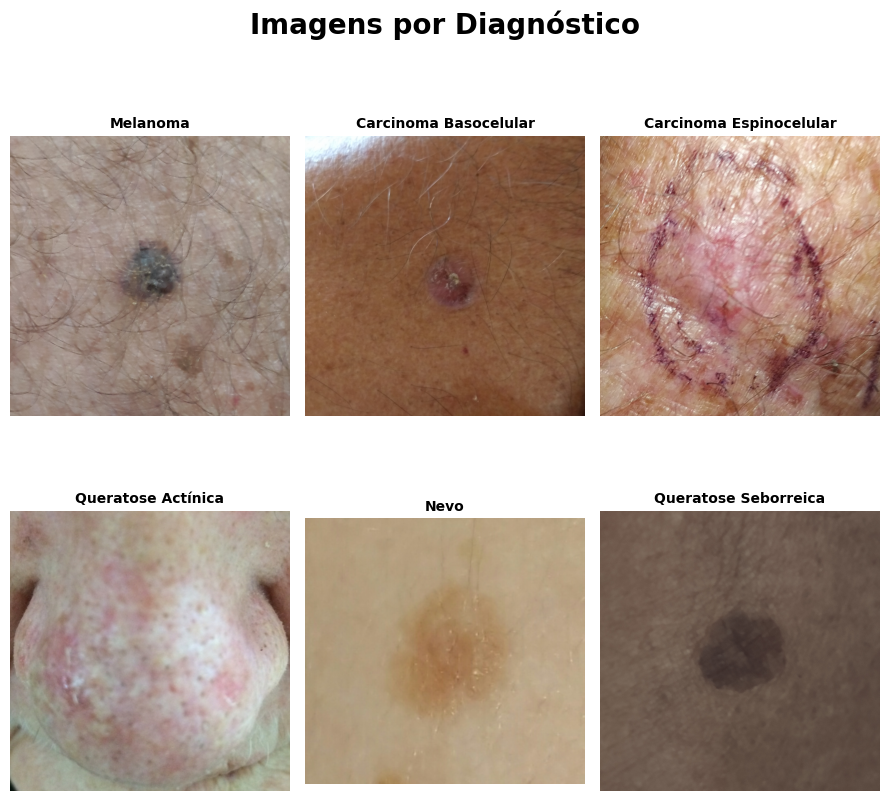

In [73]:
df = pd.read_csv('data/skincancer.csv')
plot_sample_images(df, IMAGE_DIR)

# 3. Pré-processamento

## 3.1 Agrupando maligno vs benigno

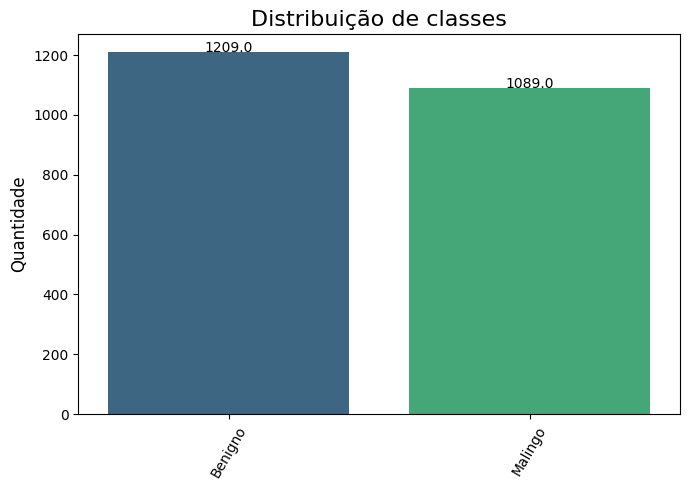

In [74]:
df.loc[:, 'diagnostic'] = \
  df['diagnostic'].map({
    'BCC': 'malignant',
    'SCC': 'malignant',
    'ACK': 'benign',
    'NEV': 'benign',
    'SEK': 'benign',
    'MEL': 'malignant'
  })

plot_class_distribution(df, label_col='diagnostic', map_label_names={
              'malignant': 'Malingo',
              'benign': 'Benigno'
          })

## 3.2 Transformando diagnóstico em números

In [75]:
labels = sorted(df['diagnostic'].unique())
label_to_int = {label: i for i, label in enumerate(labels)}
int_to_label = {i: label for label, i in label_to_int.items()}
df['label'] = df['diagnostic'].map(label_to_int)
NUM_CLASSES = len(labels)

df['label'].value_counts()


label
0    1209
1    1089
Name: count, dtype: int64

## 3.3 Divindo conjunto de treino e validação

In [76]:
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)

len(train_df), len(val_df)

(1838, 460)

## 3.4 Criando um dataset para carregar imagens

In [77]:
class SkinLesionImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['img_id']
        label = self.dataframe.iloc[idx]['label']

        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'label': torch.tensor(label, dtype=torch.long),
        }
    
transform = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # -> [-1, 1]
])

train_dataset = SkinLesionImageDataset(train_df, IMAGE_DIR, transform=transform)
val_dataset = SkinLesionImageDataset(val_df, IMAGE_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


# 4. Vision Transformer

## 4.1 Patch Embeddings

In [78]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, d_model):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2

        patch_vector_dim = patch_size * patch_size * in_channels

        self.projection = nn.Linear(patch_vector_dim, d_model)

    def forward(self, image):
        # image shape: [batch_size, in_channels, height, width]
        image = rearrange(image, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', # h = w = 224 / 16 = 14
                      p1=self.patch_size, p2=self.patch_size)

        return self.projection(image)


## 4.2 Pre-norm Transformer Encoder Block

In [79]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, ff_dim, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.mlp = FeedForward(d_model, ff_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.attention(self.norm1(x), mask)
        x = x + self.dropout(attn_output)

        ff_output = self.mlp(self.norm2(x))
        x = x + self.dropout(ff_output)

        return x

## 4.2 Implementando Vision Transformer

In [80]:
class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, num_classes,
                 d_model, n_layers, n_heads, dropout):
        super().__init__()
        self.patch_embedding = PatchEmbedding(image_size, patch_size, in_channels, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        num_patches = (image_size // patch_size) ** 2
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches + 1, d_model))
        self.transformer_encoder = nn.ModuleList([
            TransformerEncoderBlock(d_model, n_heads, d_model * 4, dropout)
            for _ in range(n_layers)
        ])

        self.final_norm = nn.LayerNorm(d_model)
        self.mlp_head = nn.Linear(d_model, num_classes)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        batch_size = x.shape[0]
    
        x = self.patch_embedding(x)

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=batch_size)

        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embedding
        x = self.dropout(x)

        for layer in self.transformer_encoder:
            x = layer(x)

        cls_output = self.final_norm(x[:, 0])
        return self.mlp_head(cls_output)

# 5. Treinamento

In [88]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import recall_score
from imblearn.metrics import specificity_score

class Trainer:
	def __init__(self, device, save_name, weights,):
		self.device = device
		self.criterion = nn.BCEWithLogitsLoss(weight=weights)
		self.save_name = save_name

	def fit(self, model, learning_rate, max_epochs, train_loader, val_loader, threshold=0.5):
		optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)

		print("\nIniciando Treinamento...")
		self.min_loss = float('inf')
		for epoch in range(max_epochs):
			train_loss = self._train_epoch(model, train_loader, optimizer, self.criterion)
			eval_validation = self.evaluate(model, val_loader, threshold)
			if eval_validation['loss'] < self.min_loss:
				self.min_loss = eval_validation['loss']
				torch.save(model.state_dict(), f'{self.save_name}')
			print(f"Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val. Loss: {eval_validation['loss']:.3f} | Val. Recall: {eval_validation['recall']*100:.2f}% | Val. FPR: {eval_validation['fpr']*100:.2f}%")

		model.load_state_dict(torch.load(self.save_name))

	def _train_epoch(self, model, iterator, optimizer, criterion):
		model.train()
		epoch_loss = 0
		for batch in iterator:
			output, label = self.get_logits_targets(model, batch)
			optimizer.zero_grad()
			output = output.squeeze(-1)
			loss = criterion(output, label.float())
			loss.backward()
			optimizer.step()
			epoch_loss += loss.item()
		return epoch_loss / len(iterator)

	def evaluate(self, model, iterator, threshold=0.5):
		model.eval()
		epoch_loss = 0
		all_preds, all_labels = [], []
		with torch.no_grad():
			for batch in iterator:
				output, label = self.get_logits_targets(model, batch)
				output = output.squeeze(-1)
				loss = self.criterion(output, label.float())
				epoch_loss += loss.item()
				preds = torch.sigmoid(output)
				all_preds.extend(preds.cpu().numpy())
				all_labels.extend(label.cpu().numpy())
		all_preds = np.array(all_preds)
		all_labels = np.array(all_labels)

		preds = (all_preds > threshold).astype(int)
		recall = recall_score(all_labels, preds, average='binary', zero_division=0)
		fpr = 1 - specificity_score(all_labels, preds, average='binary')

		return {
			'loss': epoch_loss / len(iterator),
			'recall': recall,
			'fpr': fpr,
			'preds': all_preds,
			'targets': all_labels
		}

	def get_logits_targets(self, model, batch):
		x, label = batch['image'].to(self.device), batch['label'].to(self.device)
		return model(x), label

In [82]:
def get_class_weights(num_classes, df, y_train, int_to_label, device):
    if num_classes > 2:
        weights = 1 / (torch.bincount(torch.tensor(y_train)) / len(y_train)).to(device)
        print(f"Peso da classe:")
        for i, weight in enumerate(weights):
            print(f"'{int_to_label[i]}': {weight:.2f}")
    else:
        weights = torch.tensor([df['label'].value_counts()[0] / df['label'].value_counts()[1]]).to(device)
        print(weights)

weights = get_class_weights(NUM_CLASSES, df, train_df['label'].values, int_to_label, DEVICE)

model = VisionTransformer(
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    in_channels=NUM_CHANNELS,
    num_classes=NUM_CLASSES if NUM_CLASSES > 2 else 1,
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    dropout=DROPOUT
).to(DEVICE)


tensor([1.1102], device='cuda:0', dtype=torch.float64)


In [90]:
trainer = Trainer(device=DEVICE, 
                weights=weights,
                save_name='mini_vit_model.pth')

In [84]:
trainer.fit(model,
            LEARNING_RATE,
            MAX_EPOCHS,
            train_loader,
            val_loader,
        )


Iniciando Treinamento...
Epoch: 01 | Train Loss: 0.699 | Val. Loss: 0.687 | Val. Recall: 0.00% | Val. FPR: 0.00%
Epoch: 02 | Train Loss: 0.678 | Val. Loss: 0.659 | Val. Recall: 42.66% | Val. FPR: 22.31%
Epoch: 03 | Train Loss: 0.659 | Val. Loss: 0.663 | Val. Recall: 22.48% | Val. FPR: 5.37%
Epoch: 04 | Train Loss: 0.629 | Val. Loss: 0.584 | Val. Recall: 46.79% | Val. FPR: 13.22%
Epoch: 05 | Train Loss: 0.596 | Val. Loss: 0.550 | Val. Recall: 75.23% | Val. FPR: 27.27%
Epoch: 06 | Train Loss: 0.570 | Val. Loss: 0.537 | Val. Recall: 73.85% | Val. FPR: 28.93%
Epoch: 07 | Train Loss: 0.549 | Val. Loss: 0.539 | Val. Recall: 58.26% | Val. FPR: 13.22%
Epoch: 08 | Train Loss: 0.542 | Val. Loss: 0.546 | Val. Recall: 52.29% | Val. FPR: 9.92%
Epoch: 09 | Train Loss: 0.527 | Val. Loss: 0.532 | Val. Recall: 63.30% | Val. FPR: 22.31%
Epoch: 10 | Train Loss: 0.501 | Val. Loss: 0.557 | Val. Recall: 79.82% | Val. FPR: 33.88%


In [85]:
#model.load_state_dict(torch.load('mini_vit_model.pth'))

# 6. Avaliando o modelo

In [91]:
if NUM_CLASSES == 2:
  out = trainer.evaluate(model, val_loader)
  plot_interactive_roc_curve(out['targets'], out['preds'])